In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
from tqdm.notebook import tqdm
import random
import matplotlib.pyplot as plt
from torchvision import models
import numpy as np
import random
from colour.io.luts.iridas_cube import read_LUT_IridasCube
import os
from torchvision.io import read_image
import torchvision

In [18]:
def save_model(epochs, model, optimizer, pretrained):
    """
    Function to save the trained model to disk.
    
    Args:
    - epochs (int): Number of epochs trained.
    - model: The neural network model.
    - optimizer: The optimizer used during training.
    - pretrained (bool): Indicator if the model was pretrained or not.
    
    Saves the model state, optimizer state, epoch number, and loss.
    """
    torch.save({
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, f"./outputs/model_pretrained_{pretrained}.pth")

def load_model_from_path(model, optimizer, path):
    """
    Function to load a saved model from a specified file path.

    Args:
    - model: The neural network model.
    - optimizer: The optimizer used during training.
    - path (str): The file path to the saved model.

    Returns:
    - model: The loaded neural network model.
    - optimizer: The loaded optimizer state.
    - epoch: The epoch number from the loaded model.
    """
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']

    return model, optimizer, epoch


In [3]:

def read_lut(lut_path):
    """
    Reads a LUT from the specified path, returning instance of LUT3D or LUT3x1D.
    
    Args:
    - lut_path (str): the path to the file from which to read the LUT.
    
    Returns:
    - lut: Instance of LUT3D or LUT3x1D.
    """
    lut = read_LUT_IridasCube(lut_path)
    lut.name = os.path.splitext(os.path.basename(lut_path))[0]

    return lut


def process_image(im, lut, log):
    """Applies LUT transformation to the image.
    
    Args:
    - im (torch.Tensor): Input image tensor.
    - lut: CubeLUT object containing LUT.
    - log (bool): If True, transform to log colorspace.
    
    Returns:
    - new_im (torch.Tensor): Transformed image tensor.
    """

    im = im.clamp(0, 1)  # Ensure input tensor values are between 0 and 1
    if log:
        im = im.pow(1/2.2)  # Transform to log colorspace if log is True
    
    # Convert tensors to numpy arrays
    im_array = (im.permute(1, 2, 0).cpu().numpy() / 255).astype(np.float32)
    im_array = lut.apply(im_array)  # Apply LUT transformation 

    if log:
        im = im.pow(2.2)
        
    im_array = im_array * 255
    
    # Convert numpy array back to torch tensor
    new_im = torch.from_numpy(im_array).to(im.device).permute(2, 0, 1).float()
    return new_im


# Define a class for applying random style deformations to images
class RandomStyleDeformationWithLUT:
    def __init__(self, lut_path):
        self.lut_path = lut_path
        self.lut_files = self.get_lut_files()

    def get_lut_files(self):
        return [self.lut_path + '/' + file for file in os.listdir(self.lut_path)  if file.endswith('.cube')]

    def apply_lut_transformation(self, images, lut_data):
        # Apply LUT transformation to the image
        transformed_images = []
        for batch in range(images.size(0)):
            image = images[batch,:,:,:]
            transformed_image = process_image(image, lut_data, log=False)
            transformed_images.append(transformed_image)
        return torch.stack(transformed_images)


    def __call__(self):
        '''Returns a function with predownloaded lut f(images) that returns transformed images
            Can proccess batch 
        Args for inner function:
            images (torch): _description_

        Returns a function that outputs:
            torch: _description_
        '''
        # TODO think about batch proccessing 
        # A good question here, whether I should pick just 2 transformations for batch or pick random for each image
        selected_lut_file = random.choice(self.lut_files)
        lut_data = read_lut(selected_lut_file)
        def f(images):
            transformed_images = self.apply_lut_transformation(images, lut_data)
            return transformed_images
        return f



In [4]:

# Define a custom dataset for your test images
class TestImageDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, filename) for filename in os.listdir(root_dir) if filename.endswith(('.jpeg', '.jpg', '.png'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = read_image(img_path)
        
        if self.transform:
            image = self.transform(image)

        return image




In [25]:

# Define the MatrixProductModel
class MatrixProductModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MatrixProductModel, self).__init__()
        
        self.R = nn.Parameter(torch.randn(input_dim, output_dim), requires_grad=True)
        self.Q = nn.Parameter(torch.randn(output_dim, input_dim), requires_grad=True)

    def forward(self, x, T):
        # Ensure x and T have compatible dimensions for batch operations
        # Reshape the input batch to batch_size x num_pixels x 3
        # Reshape T to batch_size x k x k

        # Perform matrix-vector multiplication Q^T * T * R * x
        
        y =  torch.matmul(torch.matmul(torch.matmul(x, self.R), T), self.Q)
        # print(x.size(),self.R.size(),T.size(),self.Q.size())
        # print(y.size())
        return y.view(y.size(0), -1, y.size(-1))  # Reshape output back to batch format


# Define the NeuralPreset model with nn.ModuleList that containes efficientnet_b0, model_n, model_s
class NeuralPreset(nn.Module):
    def __init__(self, input_dim=3, output_dim=16, image_style_transform=None, image_inner_dim=1000):
        super(NeuralPreset, self).__init__()
        self.output_dim = output_dim
        self.input_dim = input_dim

        self.model_n =  MatrixProductModel(input_dim, output_dim)
        self.model_s =  MatrixProductModel(input_dim, output_dim)


        self.efficientnet_b0 = torchvision.models.efficientnet_b0()
        # in case if you want to download the custom model
        # self.efficientnet_b0 = torch.load('efficientnet_b0.pth').eval()
        
        # Replace the final classifier with a new fully connected layer which ouputs 2*output_dim*output_dim tensor
        in_features = self.efficientnet_b0.classifier[-1].in_features
        self.efficientnet_b0.classifier[-1] = nn.Linear(in_features, 2 * output_dim * output_dim)  # 2 stands for two vectors, r and d
        # Freeze the first layer
        for i, layer in enumerate(self.efficientnet_b0.children()):
            if i < 2:
                for param in layer.parameters():
                    param.requires_grad = False
        self.efficientNet_transform = models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()


        #Style transform for learning pipeline
        self.image_style_transform = image_style_transform

        # Dimension of image representation to validate the pipeline 
        self.image_inner_dim = image_inner_dim
 
 
    def forward(self, Images):
        # Get T from the encoder
        downsampled_x = self.efficientNet_transform(Images)
        # Shape on this step is [batch, 3(rgb), 224, 224]

        #TODO we want to extract the same image style transfer inside batch to apply later on trim_Images
        lut1 = self.image_style_transform()
        lut2 = self.image_style_transform()
        downsampled_x1 = lut1(downsampled_x)
        downsampled_x2 = lut2(downsampled_x)
        
        # Output features = 256, so k is fixed to 16
        # d_i, r_i - normalized color space, color style
        d_1, r_1 = self.efficientnet_b0(downsampled_x1).chunk(2, dim=1)
        d_2, r_2 = self.efficientnet_b0(downsampled_x2).chunk(2, dim=1)

        k = self.output_dim

        #TODO We would like to apply LUt on downsample, but what we want to compare Y_i with then ...

        # make random indices to proccess not the whole image
        rand_ind = np.random.choice(range(downsampled_x.size(2)**2), self.image_inner_dim**2, replace=False)

        # Perform operations using model_n and model_s
        trim_Images = Images.view(Images.size(0),-1,3)[:,rand_ind,:].float()

        Z_1 = self.model_n(trim_Images, d_1.view(-1, k, k))  # Modify inputs for batch processing
        Z_2 = self.model_n(trim_Images, d_2.view(-1, k, k))  # Modify inputs for batch processing

        Y_1 = self.model_s(Z_2, r_1.view(-1, k, k))  # Modify inputs for batch processing
        Y_2 = self.model_s(Z_1, r_2.view(-1, k, k))  # Modify inputs for batch processing

        i_1 = lut1(trim_Images.view(Images.size(0),3,self.image_inner_dim,self.image_inner_dim)).view(Images.size(0),-1,3)
        i_2 = lut2(trim_Images.view(Images.size(0),3,self.image_inner_dim,self.image_inner_dim)).view(Images.size(0),-1,3)
        #TODO there is no reshape on output, i.e. the optup in the form of vector
        # print(Z_1.size(),Y_1.size(),i_1.size())
        return Z_1, Z_2, Y_1, Y_2, i_1, i_2
    
    def modeln(self, image, d):
        '''Color-normalizes the image based on the content vector d.

        Args:
            image (_type_): _description_
            d (_type_): _description_

        Returns:
            _type_: _description_
        '''        
        k = self.output_dim
        Z = self.model_n(image.view(image.size(0), -1, 3), d.view(-1, k, k))
        return Z
    
    def models(self, image, r):
        '''Stylizes the image based on the style vector r.

        Args:
            image (_type_): _description_
            r (_type_): _description_

        Returns:
            _type_: _description_
        '''        
        k = self.output_dim
        Y = self.model_s(image.view(image.size(0), -1, 3), r.view(-1, k, k))
        return Y
    def encoder(self, image):
        '''Downsamples the image and returns the content vector d and style vector r.
        Args:
            image (_type_): _description_
        Returns:
            _type_: _description_
        '''        
        downsampled = self.efficientNet_transform(image)
        d, r = self.efficientnet_b0(downsampled).chunk(2, dim=1)
        return d, r
    
# Custom loss function that combines L1 norms and L2 norm
def custom_loss(Z_1, Z_2, Y_1, Y_2, i_1, i_2, coef_l):
    
    # Calculate L2 norm
    l2_norm = F.mse_loss(Z_1, Z_2)

    # Calculate L1 norms
    l1_norm1 = F.l1_loss(Y_1, i_1)
    l1_norm2 = F.l1_loss(Y_2, i_2)

    # Combine the L1 norms as needed
    loss = coef_l * l2_norm + l1_norm1 + l1_norm2
    
    return loss


In [6]:
# Define the height and width for resizing
height, width = 1536, 1536

# Define image transformations
image_transform = transforms.Compose([
    transforms.Resize((height, width)),
    # transforms.ToTensor(),
])

# Path to your test images folder
data_folder = 'data'

# Create a DataLoader for your test images
dataset = TestImageDataset(data_folder, transform=image_transform)

dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

# models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()

# Create a RandomStyleDeformation object
random_style_deformation = RandomStyleDeformationWithLUT('./LUTs')

In [7]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [61]:
# Set the number of classes in your task (adjust as needed)
k = 16

# Initialize the model and optimizer with Adam
model = NeuralPreset(3,k,random_style_deformation,224).to(device)
# the downsampled size is 224x224x3
loaded_model = NeuralPreset(3,k,random_style_deformation,224).to(device) # test

In [9]:
# Lambda coefficient
coef_l = 1

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
log_interval = 0.1

number_of_batches = 2


In [67]:
model.train() 
progress_bar = tqdm(range(num_epochs), total=num_epochs)
for epoch in progress_bar:

    #TODO eval every
    for batch_idx, images in enumerate(dataloader):

        if number_of_batches is not None:
            if batch_idx == number_of_batches:
                break
        Z_1, Z_2, Y_1, Y_2, i_1, i_2 = model(images)



        # Calculate loss, coef lambda = 10
        loss = custom_loss(Z_1, Z_2, Y_1, Y_2, i_1, i_2, coef_l)

        loss.backward()
        optimizer.step()
        
        optimizer.zero_grad()
        
        # Print the loss value at each step
        progress_bar.set_postfix({"Loss": loss.item()}, refresh=False)
        # if (batch_idx + 1) % log_interval == 0:
        #     print(
        #         f"Epoch [{epoch + 1}/{num_epochs}] "
        #         f"Batch [{batch_idx + 1}/{len(dataloader)}] "
        #         f"Loss: {loss.item():.6f}"
        #         )


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\dimav\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


KeyboardInterrupt: 

In [62]:
save_model(num_epochs,model,optimizer=optimizer,pretrained=True)

In [63]:
# Example usage to load the model from a specified file path
path_to_model = "./outputs/model_pretrained_True.pth"  # Replace this with your file path
loaded_model, loaded_optimizer, loaded_epoch = load_model_from_path(loaded_model, optimizer, path_to_model)


# Usage examples

In [19]:
def plot_image_3d(image, subplot, dots=10_000):
    """Plots the 3D scatter plot of the image."""
    # Convert image into numpy array
    img_array = np.array(image) / 255
    r, g, b = img_array[:, :, 0].flatten(), img_array[:, :, 1].flatten(), img_array[:, :, 2].flatten()
    idxes = np.random.randint(0, len(r), dots)
    colors = img_array.reshape(-1, 3)

    # Plotting
    subplot.scatter(r[idxes], g[idxes], b[idxes], c=colors[idxes], alpha=0.5, s=1)

In [20]:
def reconstruct_image(model, image_path, image_transform, height, width):
    # Load the image
    image = Image.open(image_path)

    # Transform the image for inference
    image_transformed = transforms.ToTensor()(image_transform(image)).unsqueeze(0)  # Add a batch dimension
    # print(image_transformed.shape)
    # Perform inference
    with torch.no_grad():
        # Get content and style vectors for the image
        d, r = model.encoder(image_transformed)
        #TODO mind dims here
        Z = model.modeln(image_transformed.view(image_transformed.size(0),-1,3), d.view(-1, k, k))
        Y_reconstructed = model.models(Z, r.view(-1, k, k))

    # Clip values to [0, 1] range for displaying images
    Y_reconstructed = torch.clamp(Y_reconstructed, 0, 1).view(3, height, width).permute(1, 2, 0).numpy()
    Z_clipped = torch.clamp(Z, 0, 1).view(3, height, width).permute(1, 2, 0).numpy()

    fig = plt.figure(figsize=(30, 15))
    images = [image, Z_clipped, Y_reconstructed]
    
    titles = ['Content Image', 'Color-Normolized Image', 'Reconstructed Image']

    for i in range(3):
        # Display the images
        ax = fig.add_subplot(2, 3, i + 1)
        ax.imshow(images[i])
        ax.set_title(titles[i])
        ax.axis('off')

    for i in range(3):
        # Plot 3D color distributions
        ax = fig.add_subplot(2, 3, i + 4, projection='3d')
        plot_image_3d(images[i], ax)
        ax.set_title(titles[i])
        ax.set_xlabel('Red')
        ax.set_ylabel('Green')
        ax.set_zlabel('Blue')
        ax.view_init(elev=30, azim=347)

    plt.tight_layout()
    plt.show()

In [64]:
# Evaluate the trained model on an image
model.eval()
loaded_model.eval()
print('eval mode')

eval mode


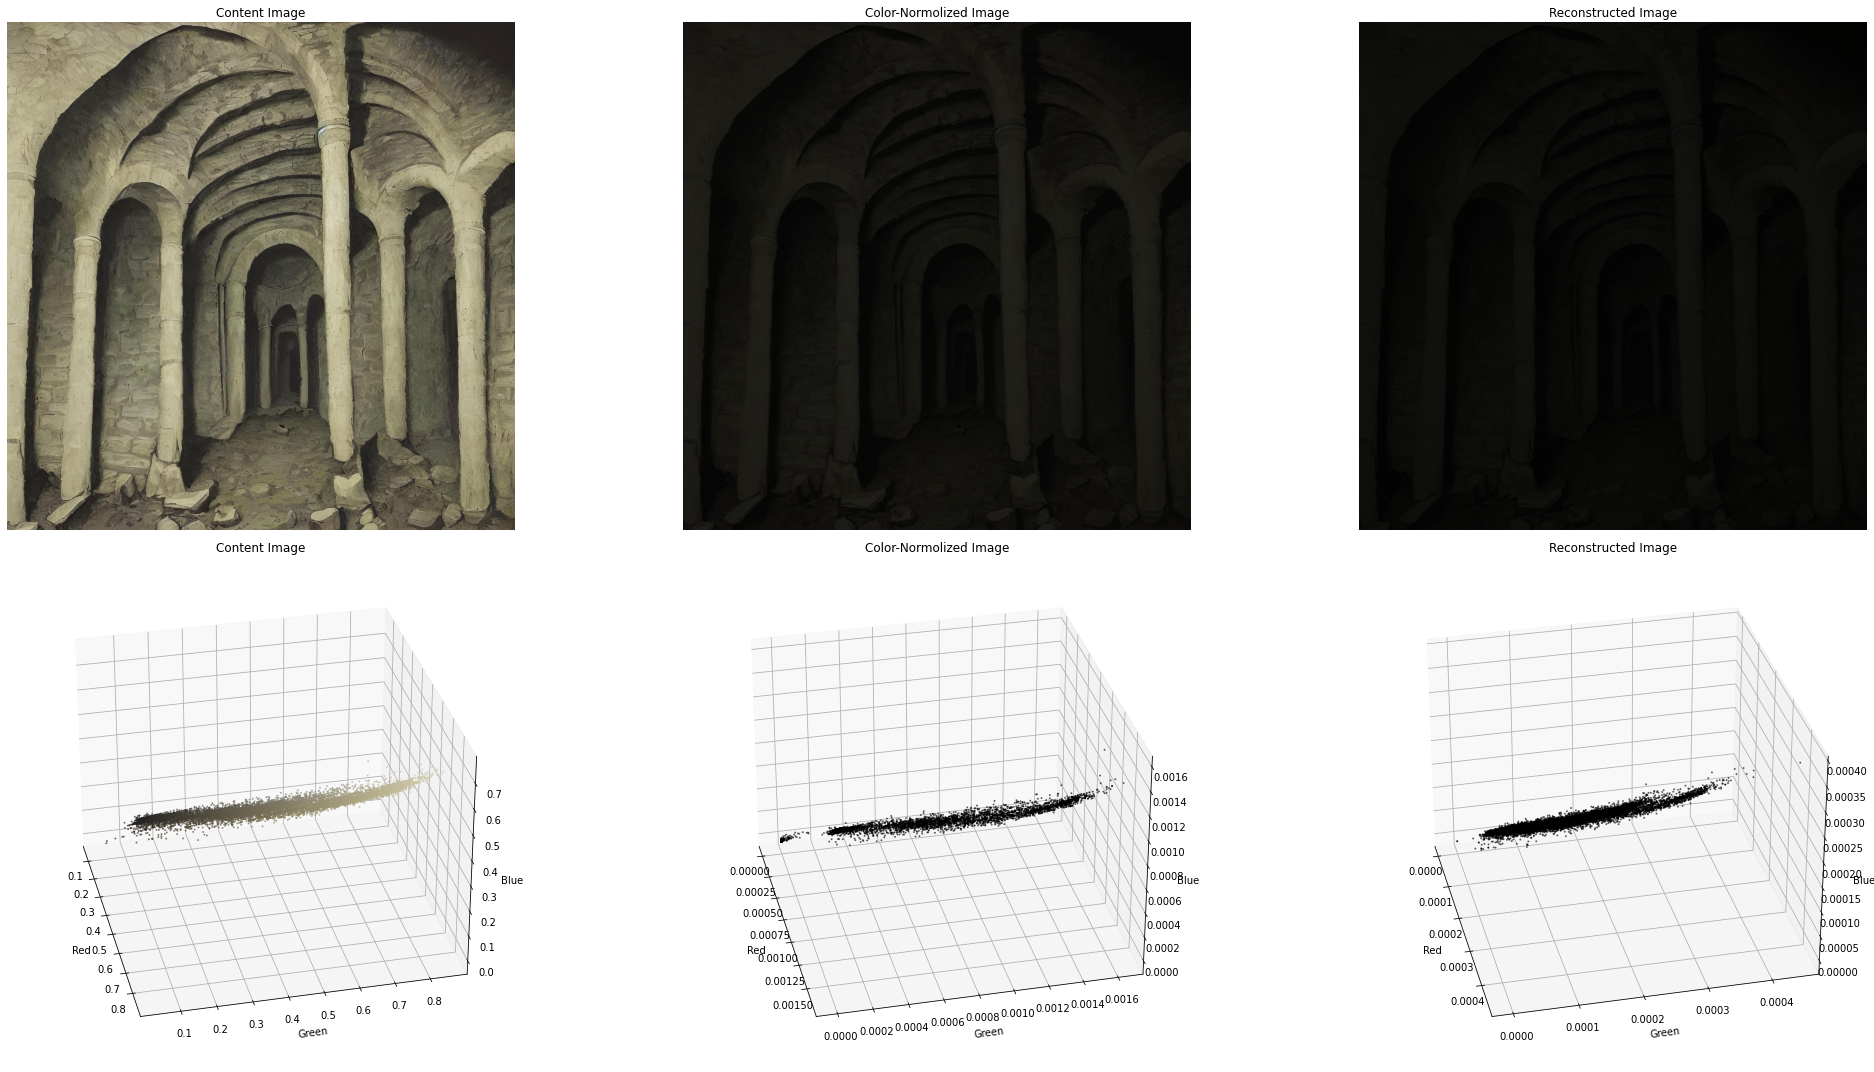

In [65]:

# Assuming you have 'model', 'image_transform', 'height', and 'width' defined previously
image_path = 'data/1687724324700842 (2).jpeg'
reconstruct_image(loaded_model, image_path, image_transform, height, width)

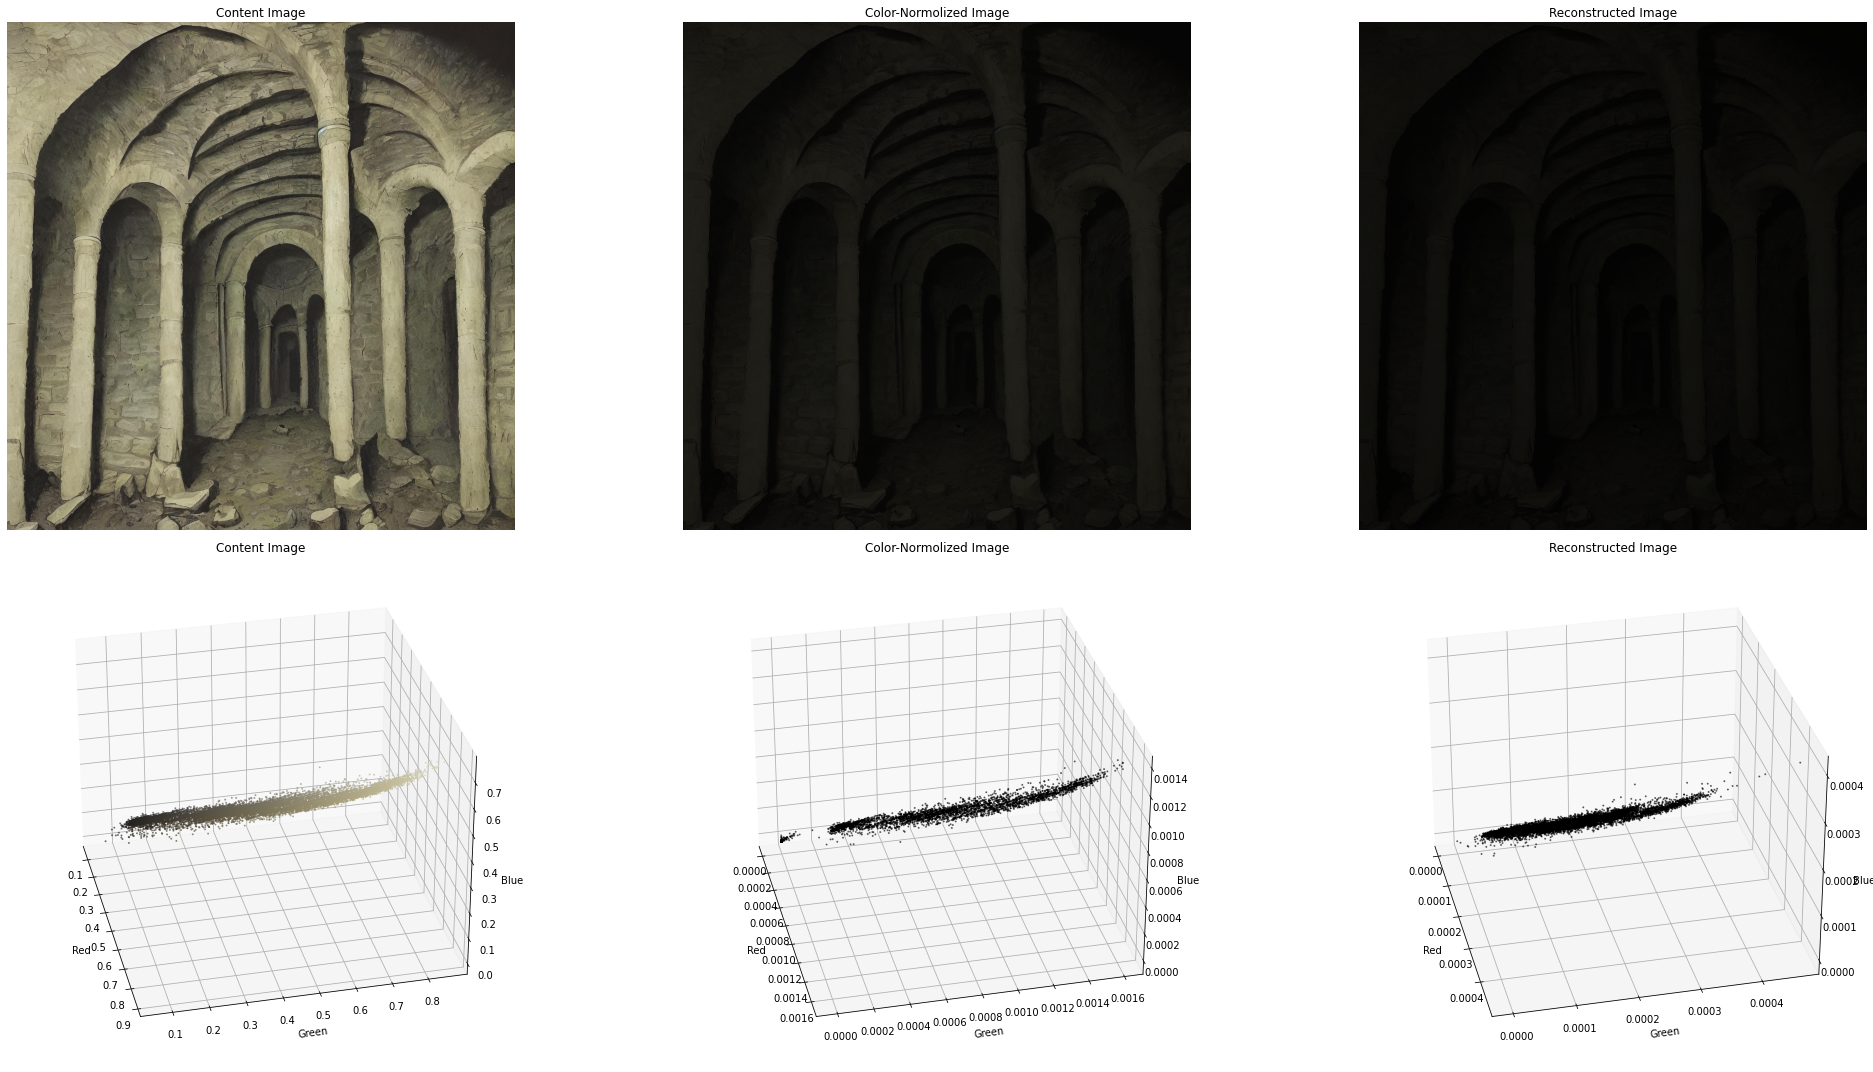

In [66]:
reconstruct_image(model, image_path, image_transform, height, width)

In [14]:
def perform_style_transfer(model, content_image_path, style_image_path, image_transform, height, width):
    # Load content and style images
    content_image = Image.open(content_image_path)
    style_image = Image.open(style_image_path)

    # Transform the images for inference
    content_transformed = transforms.ToTensor()(image_transform(content_image)).unsqueeze(0)  # Add a batch dimension for content
    style_transformed = transforms.ToTensor()(image_transform(style_image)).unsqueeze(0)  # Add a batch dimension for style


    # Perform inference
    with torch.no_grad():
        # Get content and style vectors for the respective images
        d_content, r_content = model.encoder(content_transformed)
        d_style, r_style = model.encoder(style_transformed)

        # Apply style transfer
        Z_content = model.modeln(content_transformed, d_content.view(-1, k, k))
        Y_style_transferred = model.models(Z_content, r_style.view(-1, k, k))

    # Clipping the values to [0, 1] range
    Y_style_transferred = torch.clamp(Y_style_transferred, 0, 1).view(3, height, width).permute(1, 2, 0).numpy()

    # Create a figure with subplots for all visualizations
    fig = plt.figure(figsize=(30, 15))
    images = [content_image, style_image, Y_style_transferred]
    
    titles = ['Content Image', 'Style Image', 'Style-Transferred Image']

    for i in range(3):
        # Display the images
        ax = fig.add_subplot(2, 3, i + 1)
        ax.imshow(images[i])
        ax.set_title(titles[i])
        ax.axis('off')

    for i in range(3):
        # Plot 3D color distributions
        ax = fig.add_subplot(2, 3, i + 4, projection='3d')
        plot_image_3d(images[i], ax)
        ax.set_title(titles[i])
        ax.set_xlabel('Red')
        ax.set_ylabel('Green')
        ax.set_zlabel('Blue')
        ax.view_init(elev=30, azim=347)

    plt.tight_layout()
    plt.show()


In [25]:
# Assuming you have 'model', 'image_transform', 'height', and 'width' defined previously
content_path = 'data/1687724324700842 (2).jpeg'
style_path = 'data/16805902646928945 (2).jpeg'
perform_style_transfer(model, content_path, style_path, image_transform, height, width)

In [16]:
perform_style_transfer(model, style_path, content_path, image_transform, height, width)